In [30]:
# Define model
import torch
import torch.nn as nn


def create_hidden_layers(hidden_layer_sizes):
    if not hidden_layer_sizes:
        return []

    hidden_layers = []
    for i in range(1, len(hidden_layer_sizes)):
        hidden_size = hidden_layer_sizes[i]
        hidden_layers.append(nn.Linear(hidden_layer_sizes[i - 1], hidden_size))
    return hidden_layers


class MultiHiddenLayerNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes):
        super(MultiHiddenLayerNetwork, self).__init__()

        if not hidden_layer_sizes:
            self.input_layer = nn.Linear(input_size, output_size)
            hidden_layers = []
        else:
            self.input_layer = nn.Linear(input_size, hidden_layer_sizes[0])
            hidden_layers = create_hidden_layers(hidden_layer_sizes)
            hidden_layers.append(nn.Linear(hidden_layer_sizes[-1], output_size))

        self.hidden_layers = nn.ModuleList(hidden_layers)

    def pass_forward(self, x):

        x = self.input_layer(x)
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = torch.relu(x)
            x = hidden_layer(x)
        return x


# Network that takes in all the input features and outputs a vector of qualities
class QualitiesPredictor(MultiHiddenLayerNetwork):
    def __init__(self, input_size, num_quality_scores, hidden_layer_sizes):
        super(QualitiesPredictor, self).__init__(input_size, num_quality_scores, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


# Network that takes a quality and the price and predicts the satisfaction
class SatisfactionPredictor(MultiHiddenLayerNetwork):
    def __init__(self, hidden_layer_sizes):
        super(SatisfactionPredictor, self).__init__(2, 1, hidden_layer_sizes)

    def forward(self, q, p):
        # print("Q", q.size())
        # print("P", p.size())
        x = torch.cat((q, p), dim=1)
        # print(x)
        return super().pass_forward(x)


# Takes all the quality scores and predicts a total quality variable
class TotalQualityPredictor(MultiHiddenLayerNetwork):
    def __init__(self, num_quality_scores, hidden_layer_sizes):
        super(TotalQualityPredictor, self).__init__(num_quality_scores, 1, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


class CausalModel(nn.Module):
    def __init__(self, input_size, num_quality_scores,
                 qualities_predictor_hidden_layer_sizes,
                 satisfaction_predictor_hidden_layer_sizes,
                 total_quality_predictor_hidden_layer_sizes):
        super(CausalModel, self).__init__()

        self.num_quality_scores = num_quality_scores

        self.qualities_predictor_net = QualitiesPredictor(input_size, num_quality_scores,
                                                          qualities_predictor_hidden_layer_sizes)

        self.activation_on_quality = nn.Sigmoid()

        self.satisfaction_predictors = [
            SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes) for _ in range(num_quality_scores)
        ]

        self.total_quality_predictor = TotalQualityPredictor(num_quality_scores,
                                                             total_quality_predictor_hidden_layer_sizes)

        self.total_satisfaction_predictor = SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes)

    def forward(self, x, p):

        # print("x size: ", x.size())
        qualities = self.qualities_predictor_net(x)
        qualities = self.activation_on_quality(qualities)
        # print("qualities size: ", qualities.size())

        satisfactions_outputs = []
        for i, sat_predictor in enumerate(self.satisfaction_predictors):

            one_quality = torch.unsqueeze(qualities[:, i], 1)

            # print("one quality size: ", one_quality.size())
            # print("price size: ", p.size())
            
            satisfactions_outputs.append(sat_predictor(one_quality, p))

        # print("WHYYYY")
        satisfactions = torch.cat(satisfactions_outputs, dim=1)

        # print("HELLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO")
        # print("satisfactions size: ", satisfactions.size())

        total_quality = self.total_quality_predictor(qualities)
        total_quality = self.activation_on_quality(total_quality)

        # print("total quality size: ", total_quality.size())
        # print("price size: ", p.size())
        total_satisfaction = self.total_satisfaction_predictor(total_quality, p)

        return satisfactions, total_satisfaction, total_quality

    def loss_function(self, satisfactions, total_satisfaction, satisfactions_targets, total_satisfaction_target):
        # Define custom loss function
        criterion = nn.MSELoss(reduction='sum')  # Use Mean Squared Error as the loss criterion
        # Compute the loss for satisfactions
        loss_satisfactions = criterion(satisfactions, satisfactions_targets)
        # Compute the loss for total_satisfaction
        loss_total_satisfaction = criterion(total_satisfaction, total_satisfaction_target)
        # Add up the losses with appropriate weights (if desired)
        total_loss = loss_satisfactions + loss_total_satisfaction

        return total_loss

In [31]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class CausalDataset(Dataset):
    def __init__(self, df):
        CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

        self.X = torch.tensor(df[["stars", "reviews", "rating"] + list(pd.get_dummies(df["city"]).columns)].values).float()
        self.p = torch.tensor(df[["price"]].values).float()
        self.s = torch.tensor(df[CATEGORIES].values).float()
        self.total_s = torch.tensor(df[["rating"]].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        p = self.p[idx, :]
        s = self.s[idx, :]
        total_s = self.total_s[idx, :]

        return X, p, s, total_s

In [32]:
import numpy as np
from torch.utils.data import DataLoader

data = pd.read_csv("data.csv")

# Step 2: Split the dataset into train, test, and validation sets
# Define the ratio for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Get the number of samples in the dataset
num_samples = len(data)

# Calculate the number of samples for train, test, and validation sets
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Shuffle the dataset
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the dataset into train, test, and validation sets
train_data = data.iloc[indices[:num_train]]
test_data = data.iloc[indices[num_train:num_train + num_test]]
val_data = data.iloc[indices[num_train + num_test:]]

train_set = CausalDataset(train_data)
test_set = CausalDataset(test_data)
val_set = CausalDataset(val_data)

train_loader = DataLoader(train_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=16)
val_loader = DataLoader(val_set, batch_size=1)

In [33]:
CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

NUM_FEATURES = len(data[["stars", "reviews", "rating"] + list(pd.get_dummies(data["city"]).columns)].columns)
NUM_QUALITY_SCORES = len(data[CATEGORIES].columns)

model = CausalModel(NUM_FEATURES, NUM_QUALITY_SCORES, [], [], [])
model.float()

batch_losses = []
validation_losses = []

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (X, p, target_s, target_total_s) in enumerate(train_loader):
        # print("X size: ", X.size())

        # print("p size: ", p.size())
        # print("s size: ", target_s.size())
        # print("total_s size: ", target_total_s.size())

        batch_size = len(p)
        
        optimizer.zero_grad()
        s, total_s, _total_quality = model(X, p)
        loss = model.loss_function(s, total_s, target_s, target_total_s) / batch_size
        loss.backward()
        optimizer.step()

        # Record batch loss
        batch_loss = loss.item()

        batch_losses.append(batch_loss)
        # Print batch loss
        print('Epoch [{}/{}], Batch [{}/{}], Batch Loss: {:.4f}'
              .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), batch_loss))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch_idx, (val_X, val_p, val_target_s, val_target_total_s) in enumerate(val_loader):
            batch_size = len(val_p)
            val_s, val_total_s, _val_total_quality = model(val_X, val_p)
            val_loss = model.loss_function(val_s, val_total_s, val_target_s, val_target_total_s) / batch_size
            total_val_loss += val_loss.item()

    validation_loss = total_val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    print('Epoch [{}/{}], Validation Loss: {:.4f}'
          .format(epoch+1, num_epochs, validation_loss))

Epoch [1/40], Batch [1/20], Batch Loss: 20.4356
Epoch [1/40], Batch [2/20], Batch Loss: 21.3155
Epoch [1/40], Batch [3/20], Batch Loss: 20.9800
Epoch [1/40], Batch [4/20], Batch Loss: 21.0113
Epoch [1/40], Batch [5/20], Batch Loss: 20.2899
Epoch [1/40], Batch [6/20], Batch Loss: 19.9070
Epoch [1/40], Batch [7/20], Batch Loss: 20.9008
Epoch [1/40], Batch [8/20], Batch Loss: 20.2178
Epoch [1/40], Batch [9/20], Batch Loss: 20.1886
Epoch [1/40], Batch [10/20], Batch Loss: 21.7843
Epoch [1/40], Batch [11/20], Batch Loss: 20.4154
Epoch [1/40], Batch [12/20], Batch Loss: 20.5798
Epoch [1/40], Batch [13/20], Batch Loss: 21.1066
Epoch [1/40], Batch [14/20], Batch Loss: 20.7033
Epoch [1/40], Batch [15/20], Batch Loss: 22.0017
Epoch [1/40], Batch [16/20], Batch Loss: 21.6856
Epoch [1/40], Batch [17/20], Batch Loss: 21.0489
Epoch [1/40], Batch [18/20], Batch Loss: 21.7632
Epoch [1/40], Batch [19/20], Batch Loss: 20.7944
Epoch [1/40], Batch [20/20], Batch Loss: 19.9954
Epoch [1/40], Validation Loss

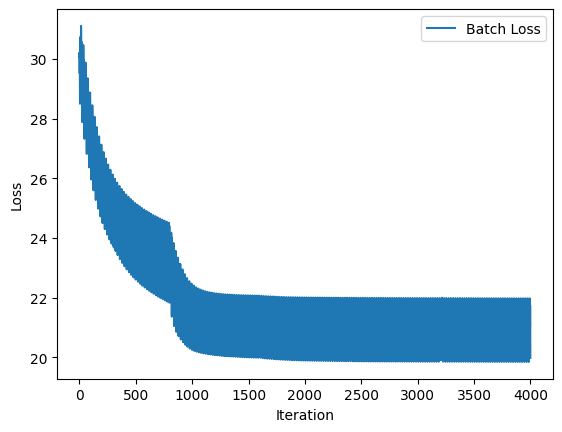

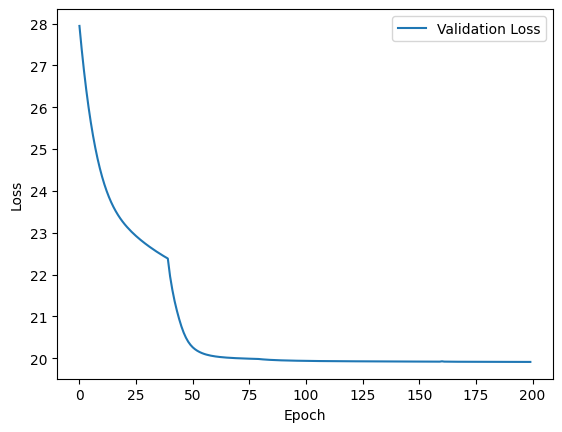

In [41]:
import matplotlib.pyplot as plt

plt.plot(batch_losses, label='Batch Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()